In [1]:
# Calculating heatwaves for Resiliency

In [16]:
import xarray as xr
import numpy as np
import cftime
import intake_esgf
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Set the matplotlib default font size
mpl.rcParams['font.size'] = 16

In [6]:
# read data
df= pd.read_csv('railonly.csv')
df_nodes = df[['dms_orig_string','dms_orig_coordinates']].drop_duplicates()
# Separate into latitude and longitude columns
df_nodes[['longitude', 'latitude']] = df_nodes['dms_orig_coordinates'].str.extract(r'\((-?\d+\.\d+),\s*(-?\d+\.\d+)\)')
# Convert columns to numeric if needed
df_nodes['longitude'] = pd.to_numeric(df_nodes['longitude'])
df_nodes['latitude'] = pd.to_numeric(df_nodes['latitude'])
# Convert negative longitudes to 0-360 range
df_nodes['longitude'] = df_nodes['longitude'] % 360
# Reset the index
df_nodes = df_nodes.reset_index(drop=True)

## Reading Daily data

In [11]:
file_pattern = '/Users/ud4/.esgf/CMIP6/*/CCCma/CanESM5/*/r1i1p1f1/day/tasmax/gn/v20190429/*.nc'
ds_daily = xr.open_mfdataset(file_pattern)

In [13]:
# Constants
threshold_kelvin = 35 + 273.15

# Extract all coordinates as DataArray for vectorized selection
lats = xr.DataArray(df_nodes['latitude'].values, dims='points')
lons = xr.DataArray(df_nodes['longitude'].values, dims='points')

# Extract all tasmax values at once using vectorized nearest selection
tasmax_all = ds_daily['tasmax'].sel(lat=lats, lon=lons, method='nearest')


# Define time boundaries as cftime.DatetimeNoLeap
date_hist_start    = cftime.DatetimeNoLeap(1991, 1, 1)
date_hist_end      = cftime.DatetimeNoLeap(2020, 12, 31)
date_future1_start = cftime.DatetimeNoLeap(2021, 1, 1)
date_future1_end   = cftime.DatetimeNoLeap(2050, 12, 31)
date_future2_start = cftime.DatetimeNoLeap(2051, 1, 1)
date_future2_end   = cftime.DatetimeNoLeap(2080, 12, 31)
date_future3_start = cftime.DatetimeNoLeap(2121, 1, 1)
date_future3_end   = cftime.DatetimeNoLeap(2150, 12, 31)

# Create masks
mask_hist     = (tasmax_all['time'] > date_hist_start) & (tasmax_all['time'] <= date_hist_end)
mask_future1  = (tasmax_all['time'] > date_future1_start) & (tasmax_all['time'] <= date_future1_end)
mask_future2  = (tasmax_all['time'] > date_future2_start) & (tasmax_all['time'] <= date_future2_end)
mask_future3  = (tasmax_all['time'] > date_future3_start) & (tasmax_all['time'] <= date_future3_end)


# Boolean arrays: days above threshold
hot_days_all = tasmax_all > threshold_kelvin


# Compute counts per point
hot_days_hist = hot_days_all.sel(time=mask_hist).sum(dim='time')
hot_days_future1 = hot_days_all.sel(time=mask_future1).sum(dim='time')
hot_days_future2 = hot_days_all.sel(time=mask_future2).sum(dim='time')
hot_days_future3 = hot_days_all.sel(time=mask_future3).sum(dim='time')

# Convert to lists if needed
list_hot_days_hist = hot_days_hist.values.tolist()
list_hot_days_future = hot_days_future1.values.tolist()
list_hot_days_future2 = hot_days_future2.values.tolist()
list_hot_days_future3 = hot_days_future3.values.tolist()

In [21]:
df_nodes_daily = df_nodes.copy(deep=True)
df_nodes_daily ['hot_days_hist'] = list_hot_days_hist
df_nodes_daily ['hot_days_future'] = list_hot_days_future
df_nodes_daily ['hot_days_future2'] = list_hot_days_future2
df_nodes_daily ['hot_days_future3'] = list_hot_days_future3
# Calculate the change in the number of hot days
df_nodes_daily['hot_days_change'] = df_nodes_daily['hot_days_future'] - df_nodes_daily['hot_days_hist']
df_nodes_daily['hot_days_change2'] = df_nodes_daily['hot_days_future2'] - df_nodes_daily['hot_days_hist']
df_nodes_daily['hot_days_change3'] = df_nodes_daily['hot_days_future3'] - df_nodes_daily['hot_days_hist']
df_nodes_daily.to_csv("hot_days_daily.csv")

Object `cbar.set_extent` not found.


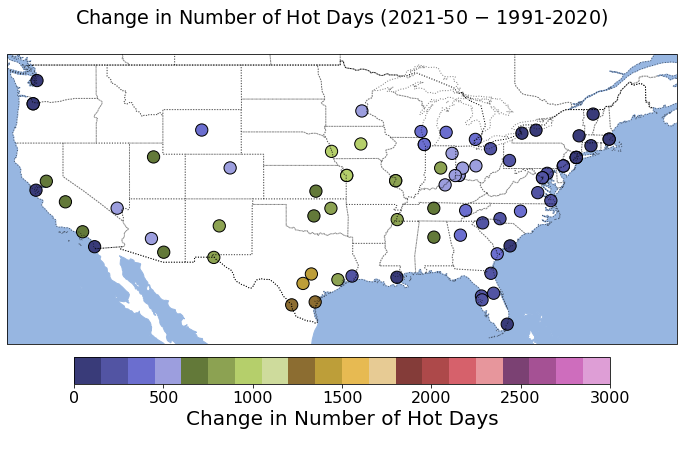

In [23]:
# Create a spatial plot of the hot days change
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent to focus on the Contiguous United States
ax.set_extent([-125, -65, 24, 50], crs=ccrs.PlateCarree())

#ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':' , alpha =.5 )
ax.add_feature(cfeature.OCEAN, linestyle='-')

# Plot data points
vmin_val =0; vmax_val = 3000
scatter = ax.scatter(df_nodes_daily['longitude'], df_nodes_daily['latitude'], 
                     c=df_nodes_daily['hot_days_change'], cmap='tab20b', 
                     s=150, edgecolor='k', transform=ccrs.PlateCarree(),
                    vmin=vmin_val, vmax = vmax_val)


# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.03, shrink = 0.8)
cbar.set_label('Change in Number of Hot Days\n', fontsize=20)
cbar.ax.tick_params(labelsize=16)
cbar.set_extent?

# Add titles and labels
plt.title('Change in Number of Hot Days (2021-50 $-$ 1991-2020) \n')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()
fig.savefig( f'plots/Change_HotDays_2021_New.pdf',bbox_inches='tight')
fig.savefig( f'plots/Change_HotDays_2021_New.png',bbox_inches='tight')

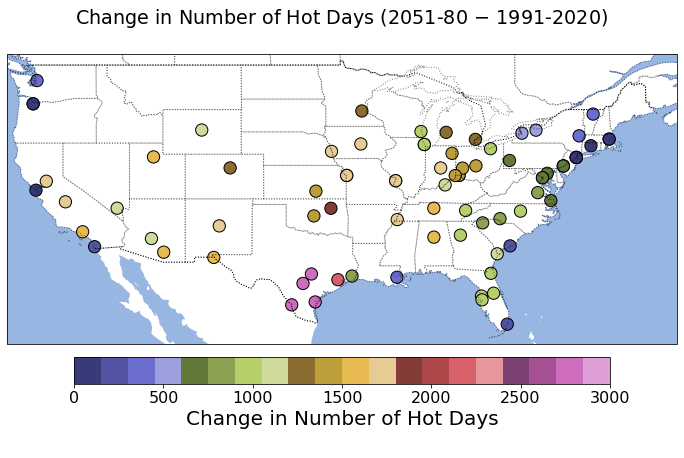

In [24]:
# Create a spatial plot of the hot days change
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent to focus on the Contiguous United States
ax.set_extent([-125, -65, 24, 50], crs=ccrs.PlateCarree())


ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':' , alpha =.5 )
ax.add_feature(cfeature.OCEAN, linestyle='-')

# Plot data points
vmin_val =0; vmax_val = 3000
scatter = ax.scatter(df_nodes_daily['longitude'], df_nodes_daily['latitude'], 
                     c=df_nodes_daily['hot_days_change2'], cmap='tab20b', 
                     s=150, edgecolor='k', transform=ccrs.PlateCarree(),
                    vmin=vmin_val, vmax = vmax_val)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.03, shrink = 0.8)
cbar.set_label('Change in Number of Hot Days\n', fontsize=20)
cbar.ax.tick_params(labelsize=16)

# Add titles and labels
plt.title('Change in Number of Hot Days (2051-80 $-$ 1991-2020) \n')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

fig.savefig( f'plots/Change_HotDays_2051_New.pdf',bbox_inches='tight')
fig.savefig( f'plots/Change_HotDays_2051_New.png',bbox_inches='tight')

plt.show()

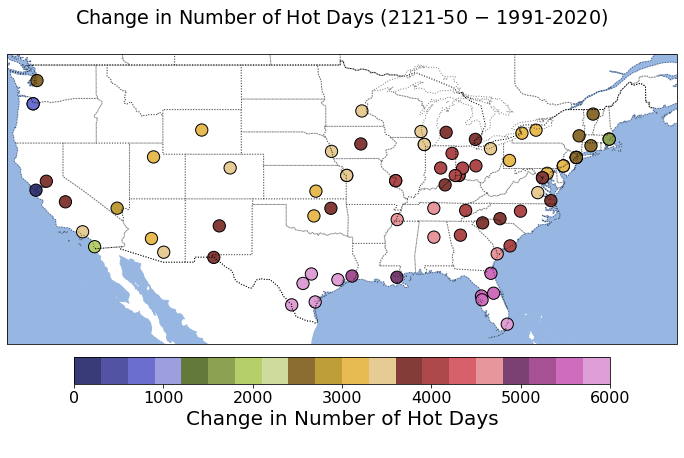

In [26]:
# Create a spatial plot of the hot days change
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent to focus on the Contiguous United States
ax.set_extent([-125, -65, 24, 50], crs=ccrs.PlateCarree())


ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':' , alpha =.5 )
ax.add_feature(cfeature.OCEAN, linestyle='-')

# Plot data points
vmin_val =0; vmax_val = 6000
scatter = ax.scatter(df_nodes_daily['longitude'], df_nodes_daily['latitude'], 
                     c=df_nodes_daily['hot_days_change3'], cmap='tab20b', 
                     s=150, edgecolor='k', transform=ccrs.PlateCarree(),
                    vmin=vmin_val, vmax = vmax_val)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.03, shrink = 0.8)
cbar.set_label('Change in Number of Hot Days\n', fontsize=20)
cbar.ax.tick_params(labelsize=16)

# Add titles and labels
plt.title('Change in Number of Hot Days (2121-50 $-$ 1991-2020) \n')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

fig.savefig( f'plots/Change_HotDays_2121_New.pdf',bbox_inches='tight')
fig.savefig( f'plots/Change_HotDays_2121_New.png',bbox_inches='tight')

plt.show()

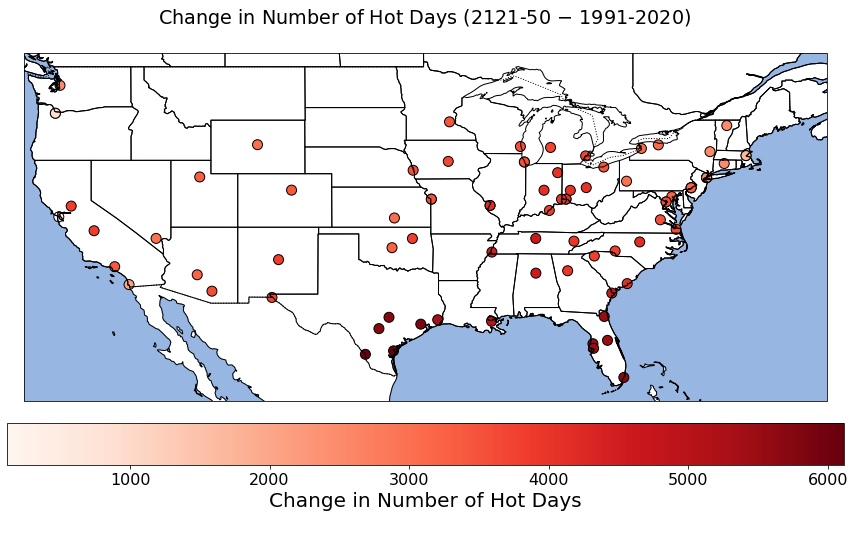

In [22]:
# Create a spatial plot of the hot days change
fig = plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent to focus on the Contiguous United States
ax.set_extent([-125, -65, 24, 50], crs=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle='-')
ax.add_feature(cfeature.OCEAN, linestyle='-')

# Plot data points
scatter = ax.scatter(df_nodes_daily['longitude'], df_nodes_daily['latitude'], 
                     c=df_nodes_daily['hot_days_change3'], cmap='Reds', 
                     s=100, edgecolor='k', transform=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label('Change in Number of Hot Days\n', fontsize=20)


# Add titles and labels
plt.title('Change in Number of Hot Days (2121-50 $-$ 1991-2020) \n')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

fig.savefig( f'plots/Change_HotDays_2121.pdf',bbox_inches='tight')
fig.savefig( f'plots/Change_HotDays_2121.png',bbox_inches='tight')

plt.show()

## end